In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import glob
%matplotlib inline


# Camera calibration and distortion correction

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

nx = 9
ny = 6
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

In [3]:
def get_camera_calibration(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    

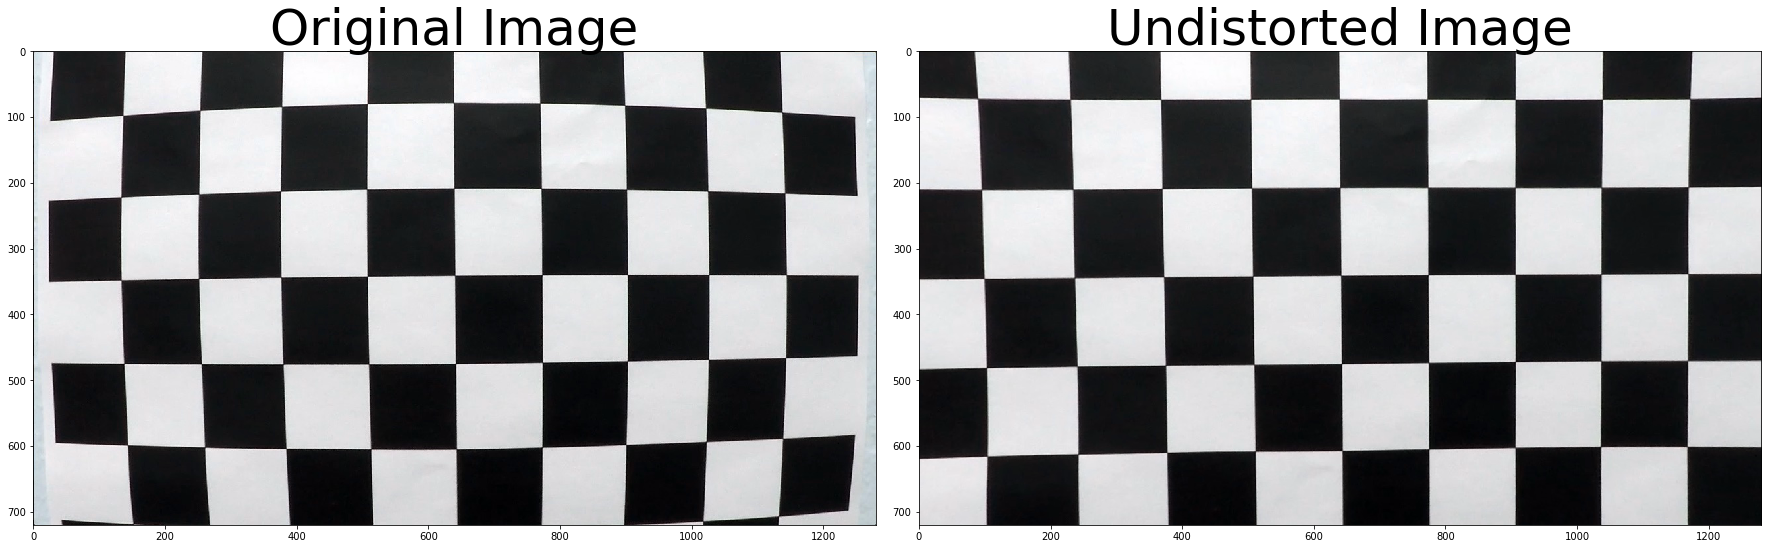

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
mtx, dist = get_camera_calibration(img, objpoints, imgpoints)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def get_undistorted_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

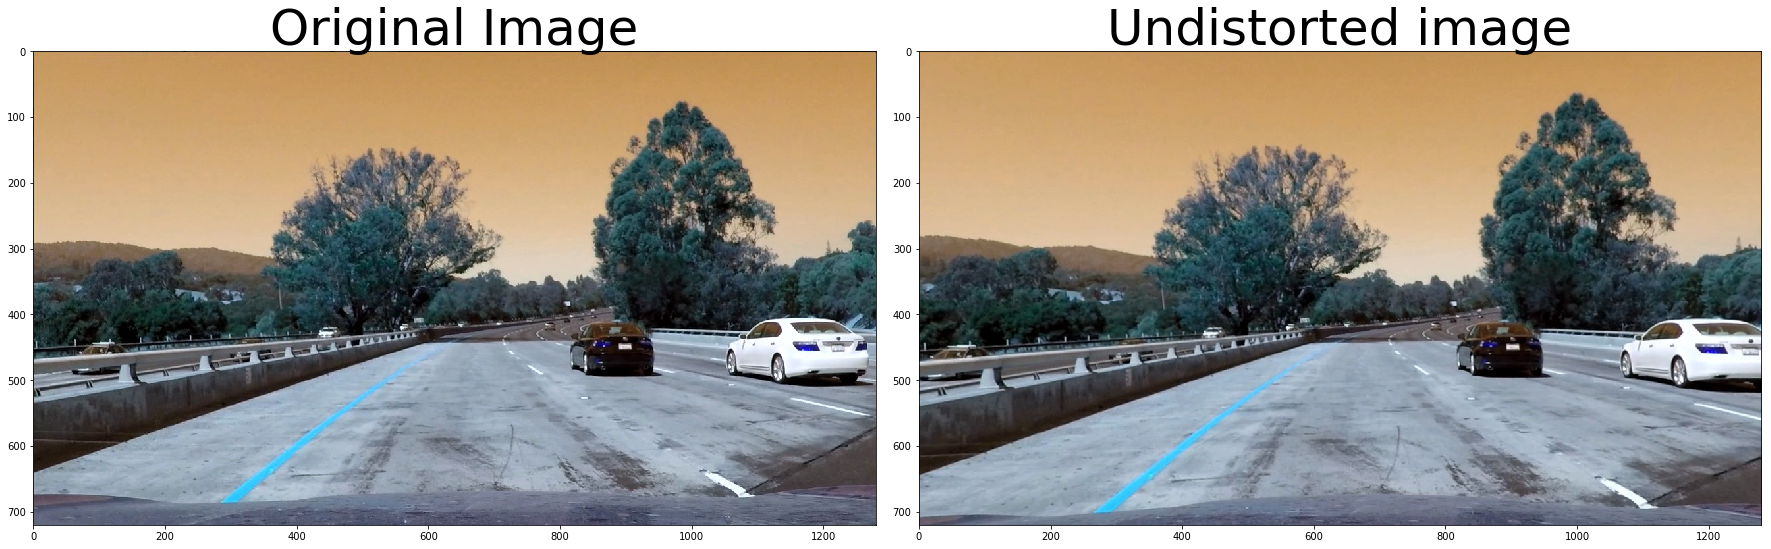

In [6]:
img = cv2.imread('test_images/test1.jpg')
undist_img = get_undistorted_image(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [21]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    thresh_min, thresh_max = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    masked_sobel = np.zeros_like(scaled_sobel)
    masked_sobel[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return masked_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.power(sobel_x, 2)+np.power(sobel_y, 2))
    sobel_scaled = np.uint8(255*sobel_mag/np.max(sobel_mag))
    sobel_mask = np.zeros_like(sobel_scaled)
    sobel_mask[(sobel_scaled>mag_thresh[0]) & (sobel_scaled<mag_thresh[1])] =1
    return sobel_mask

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0]) & (s<=thresh[1])] = 1
    return binary_output

def get_thresholded_binary_image(image, ksize = 15):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(70, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(120, 255))
    combined = np.zeros_like(dir_binary)
    combined[ ((dir_binary == 1) &(grady==1) &(mag_binary==1)) |(hls_binary==1) ] = 1
    return combined


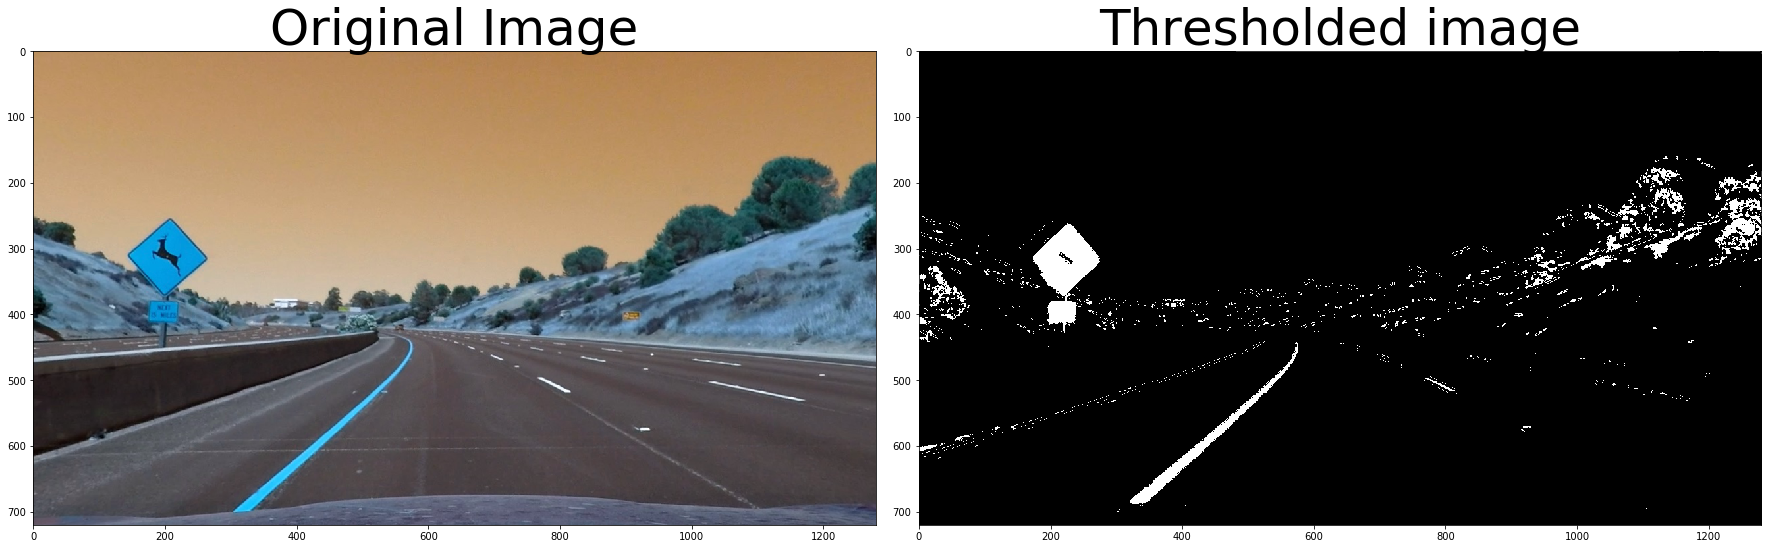

In [22]:
image = cv2.imread('test_images/test2.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


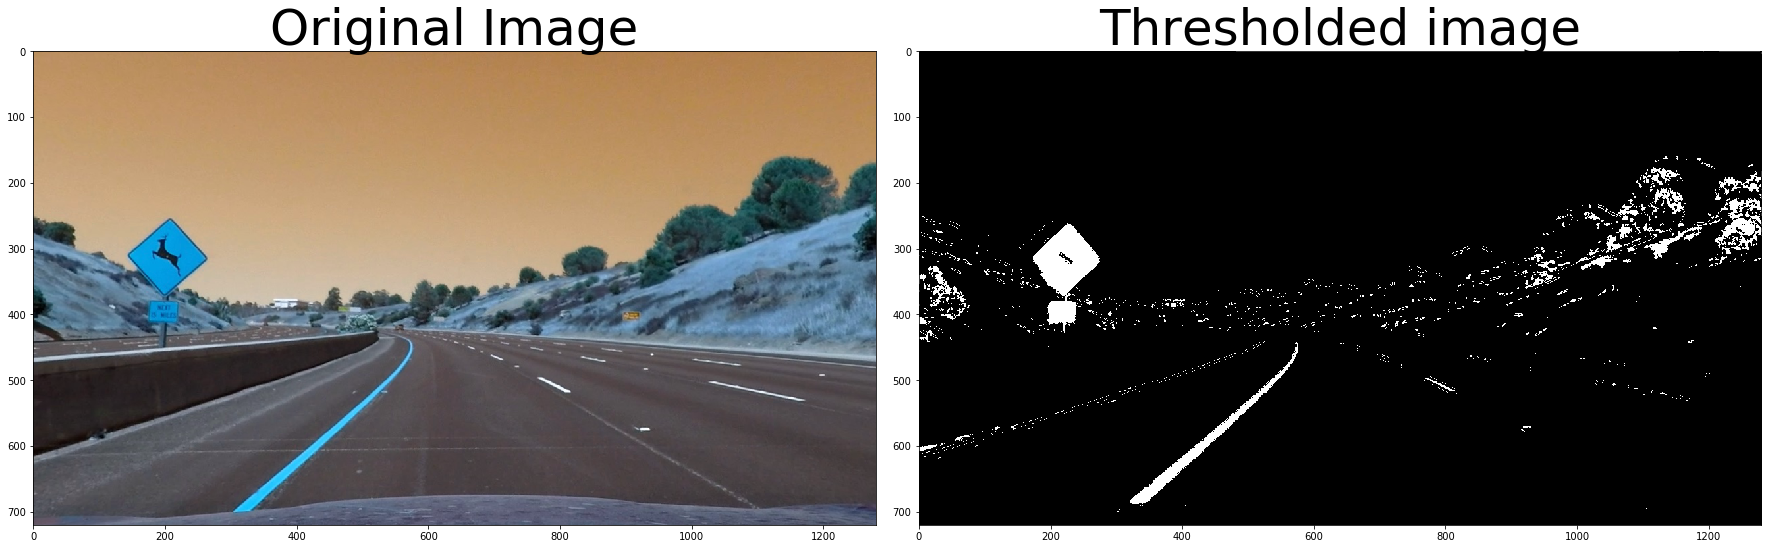

In [23]:
image = cv2.imread('test_images/test2.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


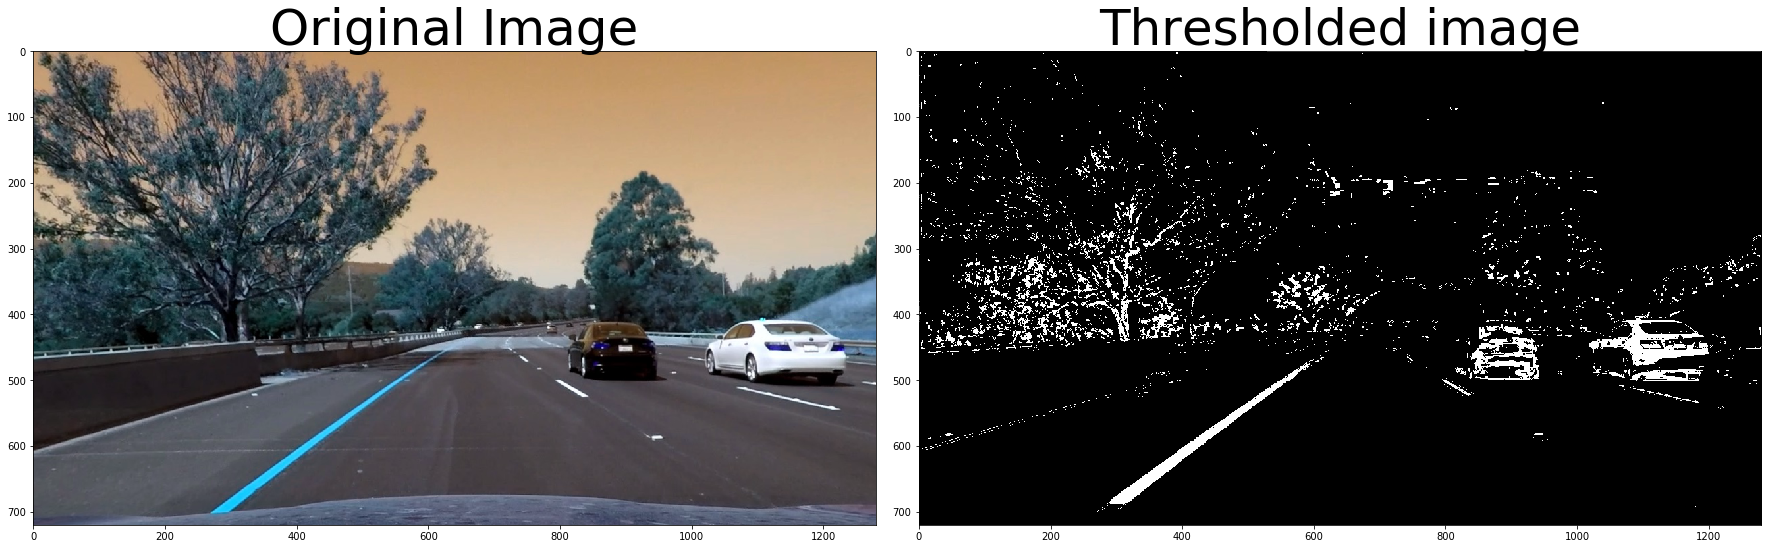

In [24]:
image = cv2.imread('test_images/test6.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [25]:
def get_warp_matrix(undist_image):
    undist_img = undist_image.copy()
    gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[img_size[0]//7+20,img_size[1]],#img_size[0]//7, img_size[1]],
                      [(6*img_size[0])//7+30, img_size[1]],
                      [img_size[0]//2+60, img_size[1]//2+100],
                      [img_size[0]//2-60, img_size[1]//2+100]])
    print(src)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    offset=200
    dst = np.float32([[offset, img_size[1]], 
                     [img_size[0]-offset, img_size[1]],
                     [img_size[0]-offset,0],
                     [offset, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist_img, M, img_size)
    return warped, M, Minv, src, dst

In [26]:
image = cv2.imread('test_images/straight_lines1.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
warped_img, perspective_M, perspective_Minv, _, dst = get_warp_matrix(undist_img)

[[  202.   720.]
 [ 1127.   720.]
 [  700.   460.]
 [  580.   460.]]


In [27]:
#perspective_M, perspective_Minv
def get_transformed_image(img, perspective_M):
    img_size = (img.shape[1], img.shape[0])
    warped_img = cv2.warpPerspective(img, perspective_M, img_size)
    return warped_img

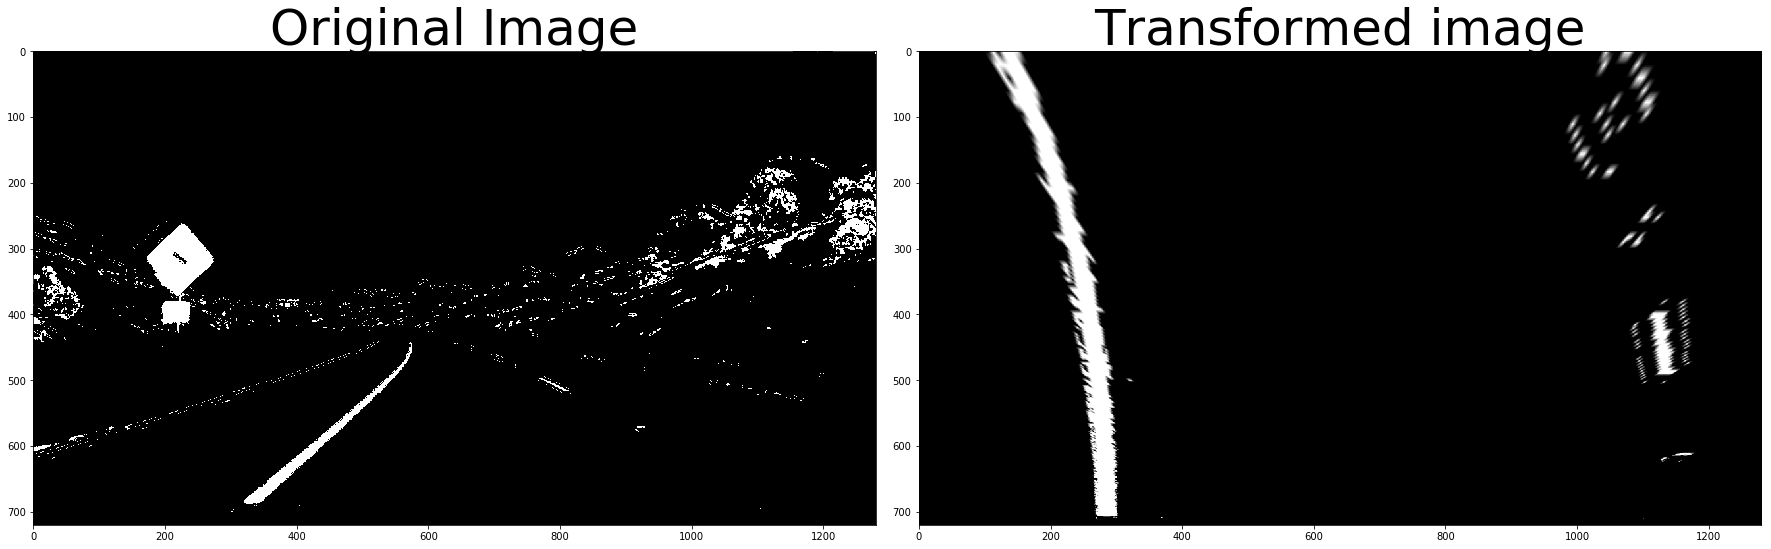

In [31]:
image = cv2.imread('test_images/test2.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

warped_img = get_transformed_image(combined, perspective_M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Transformed image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)